<h1>Содержание<span class="tocSkip"></span></h1>
<br>
<div class="toc">
    <ul class="toc-item">
        <li>
            <span>
                <a href="#1-Подготовка-окружения">
                    <span class="toc-item-num">1&nbsp;&nbsp;</span>
                    Подготовка окружения
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#2-Загрузка-данных">
                    <span class="toc-item-num">2&nbsp;&nbsp;</span>
                    Загрузка данных
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#3-Пословная-токенизация">
                    <span class="toc-item-num">3&nbsp;&nbsp;</span>
                    Пословная токенизация
                </a>
            </span>
            <ul class="toc-item">
                <li>
                    <span>
                        <a href="#3.1-Токенизация-слов">
                            <span class="toc-item-num">3.1&nbsp;&nbsp;</span>
                            Токенизация слов
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.2-Формирование-датасета">
                            <span class="toc-item-num">3.2&nbsp;&nbsp;</span>
                            Формирование датасета
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.3-Построение-модели">
                            <span class="toc-item-num">3.3&nbsp;&nbsp;</span>
                            Построение модели
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.4-Обучение-модели">
                            <span class="toc-item-num">3.4&nbsp;&nbsp;</span>
                            Обучение модели
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.5-Генерация-текста">
                            <span class="toc-item-num">3.5&nbsp;&nbsp;</span>
                            Генерация текста
                        </a>
                    </span>
                </li>
            </ul>
        </li>
        <li>
            <span>
                <a href="#4-Общий-вывод">
                    <span class="toc-item-num">4&nbsp;&nbsp;</span>
                    Общий вывод
                </a>
            </span>
        </li>
    </ul>
</div>

# Генеративные текстовые нейросети | Simple RNN (посимвольная)

**Постановка задачи:** натренировать и сравнить качество нескольких генеративных текстовых моделей на одном из заданных текстовых датасетов.

**Источник данных:** [Harry Potter and the Methods of Rationality](https://hpmor.ru/).

**Характер данных:** текст книги "Гарри Поттер и методы рационального мышления".

**Основные этапы:** исследовать следующие нейросетевые архитектуры:

1. Simple RNN с посимвольной и пословной токенизацией.
2. Однонаправленная однослойная и многослойная LSTM c посимвольной токенизацией и токенизацией по словам и [на основе BPE](https://keras.io/api/keras_nlp/tokenizers/byte_pair_tokenizer/).
3. Двунаправленная LSTM.
4. *(На хорошую оценку)* трансформерная архитектура (GPT) "с нуля" [пример](https://keras.io/examples/generative/text_generation_gpt/).
5. *(На отличную оценку)* дообучение предобученной GPT-сети [пример](https://github.com/ZotovaElena/RuGPT3_finetuning).

---

# Реализации

1. [RNN с посимвольной токенизацией](RNN_char.ipynb)
2. RNN с пословной токенизацией (текущий файл)
3. [Однонаправленная LSTM + BPE](unidirectional_LSTM_BPE.ipynb)
4. [Двунаправленная LSTM](bidirectional_LSTM.ipynb)
5. [Архитектура GPT](GPT_architecture.ipynb)
6. [Дообучение GPT](GPT_finetuning.ipynb)

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 1 Подготовка окружения

Импорт библиотек:

In [1]:
import numpy as np

from typing import Tuple
import os
import re

import tensorflow as tf
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow import keras

from keras import Sequential
from keras.callbacks import ModelCheckpoint, History
from keras.layers import Dense, LSTM, Embedding
from keras.losses import SparseCategoricalCrossentropy
from keras.utils import plot_model

from utils.useful_funcs import request_url, get_url_data, get_data, prepare_dataset, \
                               text_vector_sample, print_single_batch, test_single_model, \
                               print_single_dim, plot_performance, predict_next

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 2 Загрузка данных

Проверка наличия папки для хранения наборов данных:

In [2]:
if os.path.isdir('data/') == False:
    os.mkdir('data/')

Задание пути к файлу с основным набором данных:

In [3]:
path_file = 'data/hpmor.txt'

Формирование/загрузка набора данных в зависимости от его наличия:

In [4]:
try:
    with open(path_file, 'r', encoding='utf-8') as file:
        text = file.read()
    
    print('Uploaded from', path_file)
    
except:
    text = get_data('https://hpmor.ru/')
    
    with open(path_file, 'w', encoding='utf-8') as file:
        file.write(text)
    
    print('Saved to', path_file)

Uploaded from data/hpmor.txt


Выведение на экран начала текста:

In [5]:
text[:500]

'гарри поттер и методы рационального мышления. элиезер юдковский (less wrong). петуния вышла замуж не за дурсля, а за университетского профессора, и гарри попал в гораздо более благоприятную среду. у него были частные учителя, дискуссии с отцом, а главное — книги, сотни и тысячи научных и фантастических книг. в 11 лет гарри знаком с квантовой механикой, когнитивной психологией, теорией вероятностей и другими вещами. но гарри не просто вундеркинд, у него есть загадочная тёмная сторона, которая явн'

Выведение на экран общего числа слов в тексте:

In [6]:
print('Всего слов:', len(text.split(' ')))

Всего слов: 559855


Разделение текста на отдельные предложения:

In [7]:
text_sentences = [re.sub('[^а-яА-ЯёЁ0-9 ,-]', '', s).strip() for s in text.split('.')]

Выведение на экран начала текста:

In [8]:
text_sentences[:5]

['гарри поттер и методы рационального мышления',
 'элиезер юдковский',
 'петуния вышла замуж не за дурсля, а за университетского профессора, и гарри попал в гораздо более благоприятную среду',
 'у него были частные учителя, дискуссии с отцом, а главное  книги, сотни и тысячи научных и фантастических книг',
 'в 11 лет гарри знаком с квантовой механикой, когнитивной психологией, теорией вероятностей и другими вещами']

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 3 Пословная токенизация

### 3.1 Токенизация слов

Получение словаря уникальных слов текста:

In [9]:
vocabulary = np.array(sorted(set(' '.join(text_sentences).split(' '))))

Выведение на экран уникальных слов текста:

In [10]:
vocabulary

array(['', ',', '-', ..., 'ёовтен', 'ёрзал', 'ёрзали'], dtype='<U70')

Формирование словаря токенов:

In [11]:
tokenizer = {char: i for i, char in enumerate(vocabulary)}

Выведение на экран начала словаря токенов:

In [12]:
list(zip(list(tokenizer.keys())[:10], list(tokenizer.values())[:10]))

[('', 0),
 (',', 1),
 ('-', 2),
 ('-20', 3),
 ('-20,', 4),
 ('-лучам', 5),
 ('-лучами', 6),
 ('-лучах', 7),
 ('-лучей', 8),
 ('-лучей,', 9)]

---

### 3.2 Формирование датасета

Преобразование текста в вектор на основе токенов:

In [13]:
vector = np.array([tokenizer[word] for word in ' '.join(text_sentences).split()])

Выведение на экран части исходного текста и его векторного представления:

In [14]:
text_vector_sample(text, vector)

Исходный текст:
 гарри поттер и методы рационального мышления. элиезер юдковский (less wrong). петуния вышла замуж не 

Векторное представление:
 [ 7866 38158 15738 22281 45053 23368 60539 60776 33452  7709 13911 25152
 12535 11670   321 12535 56260 42402 15738  7866 37071  3192  8570  2529
  2190 51388 54875 25508  3122 59001 57370 10334 46156 31731   321  8098
 18351 50612 15738 54718 24950 15738 57598 18338  3192    52 20462  7866
 15505 46156 17964 22304 18408 42799 53509  3735 15738 11490  3958 27042
  7866 25152 42167  6473 54875 25508 12009 12925 54815 51961 19266 60880
 23997 47115 31302 23457 11865 23363   483 38847 17466 33496 46029 16133
 12023  3192 42487 24267  7866 38158 15738 22281 45053 23368 13963 32683
 22150 33997 37192  3192]


Формирование набора данных из срезов вектора текста:

In [15]:
vector = Dataset.from_tensor_slices(vector)

Формирование последовательностей по заданному количеству символов:

In [16]:
sequences = vector.batch(100, drop_remainder=True) 

Формирование датасета:

In [17]:
dataset = sequences.map(prepare_dataset)

Выведение на экран первой входящей последовательности и соответствующего ей сдвига:

In [18]:
print_single_batch(dataset, vocabulary, word=True)

Векторное представление:
[ 7866 38158 15738 22281 45053 23368 60539 60776 33452  7709 13911 25152
 12535 11670   321 12535 56260 42402 15738  7866 37071  3192  8570  2529
  2190 51388 54875 25508  3122 59001 57370 10334 46156 31731   321  8098
 18351 50612 15738 54718 24950 15738 57598 18338  3192    52 20462  7866
 15505 46156 17964 22304 18408 42799 53509  3735 15738 11490  3958 27042
  7866 25152 42167  6473 54875 25508 12009 12925 54815 51961 19266 60880
 23997 47115 31302 23457 11865 23363   483 38847 17466 33496 46029 16133
 12023  3192 42487 24267  7866 38158 15738 22281 45053 23368 13963 32683
 22150 33997 37192]
[38158 15738 22281 45053 23368 60539 60776 33452  7709 13911 25152 12535
 11670   321 12535 56260 42402 15738  7866 37071  3192  8570  2529  2190
 51388 54875 25508  3122 59001 57370 10334 46156 31731   321  8098 18351
 50612 15738 54718 24950 15738 57598 18338  3192    52 20462  7866 15505
 46156 17964 22304 18408 42799 53509  3735 15738 11490  3958 27042  7866
 25152

Задание констант:

In [19]:
BATCH_SIZE = 100
BATCHES_PER_EPOCH = len(sequences) // BATCH_SIZE

Формирование датасета с делением на батчи:

In [20]:
data = dataset.batch(BATCH_SIZE, drop_remainder=True).repeat()
data = data.prefetch(AUTOTUNE)

Выведение на экран размерностей первой входящей последовательности и соответствующего ей сдвига:

In [21]:
print_single_dim(data)

Размерность входящей последовательности: (100, 99)
Размерность целевой последовательности: (100, 99)


---

### 3.3 Построение модели

Задание модели:

In [22]:
rnn = Sequential([
    Embedding(len(vocabulary), BATCH_SIZE, batch_input_shape=[BATCH_SIZE, None]),
    LSTM(512, return_sequences=True, stateful=True),
    LSTM(512, return_sequences=True, stateful=True),
    Dense(len(vocabulary))
])

Выведение на экран таблицы поведения параметров на словях нейросети:

In [23]:
rnn.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (100, None, 100)          6108100   
                                                                 
 lstm (LSTM)                 (100, None, 512)          1255424   
                                                                 
 lstm_1 (LSTM)               (100, None, 512)          2099200   
                                                                 
 dense (Dense)               (100, None, 61081)        31334553  
                                                                 
Total params: 40,797,277
Trainable params: 40,797,277
Non-trainable params: 0
_________________________________________________________________


Проверка наличия папки для хранения изображений:

In [24]:
if os.path.isdir('images/') == False:
    os.mkdir('images/')

Выведение на экран отображения послойной обработки данных моделью:

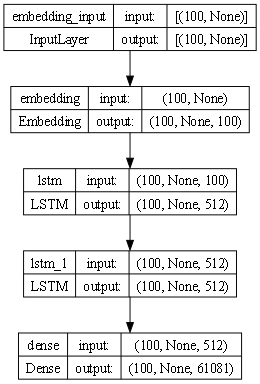

In [25]:
plot_model(rnn, 'images/rnn_word_model.png', show_shapes=True, dpi=70)

Проверка модели на восприятие датасета на примере первой последовательности:

In [26]:
test_single_model(rnn, data, vocabulary)

Размерность целевой последовательности: (100, 99)
Размерность предсказанной последовательности: (100, 99, 61081)
Размерность тензора с 1 индексом классов (99, 1)
Индекс класса: 46701 (сбавляя)


---

### 3.4 Обучение модели

Проверка наличия папки для хранения контрольных точек:

In [27]:
if os.path.isdir('checkpoints/') == False:
    os.mkdir('checkpoints/')

Задание пути для хранения контрольных точек:

In [28]:
path_checkpoints = 'checkpoints/rnn_word'

Проверка наличия папки для хранения контрольных точек:

In [29]:
if os.path.isdir(path_checkpoints) == False:
    os.mkdir(path_checkpoints)

Задание коллбека точек сохранения:

In [30]:
checkpoint_path = os.path.join(path_checkpoints, 'checkpoint_{epoch}')
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True)

Компиляция модели с оптимизатором и функцией потерь:

In [31]:
rnn.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=True))

Обучение модели:

In [ ]:
history = rnn.fit(
    data, 
    epochs=20, 
    steps_per_epoch=BATCHES_PER_EPOCH, 
    callbacks=[checkpoint_callback]
)

Epoch 1/20
34/53 [==================>...........] - ETA: 2:58 - loss: 9.3323

Выведение на экран графика значений функции потерь:

In [ ]:
plot_performance(history, 'Значение функции потерь')

Сброс состояния модели:

In [ ]:
rnn.reset_states()

---

### 3.5 Генерация текста

Выведение на экран результата предсказаний:

In [ ]:
predict_next(
    sample='гарри поттер отправился на поиски', 
    model=rnn,
    tokenizer=tokenizer,
    vocabulary=vocabulary,
    n_char_word=100, 
    temperature=0.6,
    batch_size=BATCH_SIZE,
    word=True
)

Выведение на экран результата предсказаний:

In [ ]:
predict_next(
    sample='гермиона читала книгу', 
    model=rnn,
    tokenizer=tokenizer,
    vocabulary=vocabulary,
    n_char_word=100, 
    temperature=0.8,
    batch_size=BATCH_SIZE,
    word=True
)

>Модель продемонстрировала относительно неплохую способность к построению текстов с содержащимся в них смыслом.

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 4 Общий вывод

Результаты проведённого эксперимента можно улучшить за счёт усложения модели посредством изменения её слоёв, а также большего числа итераций обучения. Однако в рамках поставленной задачи, которая заключалась в построении простой модели RNN с посимвольной токенизацией, результаты обучения можно назвать удовлетворительными. 

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Содержание" data-toc-modified-id="Содержание" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        В начало файла ↑
    </a>
</div>